# CS 422 Course Project: Customer Segmentation with K-Means
# Student Name: [Changming Yao]
# Date: May 29, 2025

# -----------------------------------------------------------------------------
# 1. Project Setup and Library Imports
# -----------------------------------------------------------------------------
# Description: Importing necessary libraries for data manipulation,
# numerical operations, clustering, and visualization.
# Justification: Standard libraries for data science tasks.
# - pandas for data handling
# - numpy for numerical operations
# - matplotlib and seaborn for plotting
# - sklearn.cluster for K-Means algorithm
# - sklearn.preprocessing for potential scaling (though not strictly needed for K-Means on these features if ranges are comparable,
#   but good practice to consider)
# -----------------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler # Optional: if feature scaling is desired

print("Libraries imported successfully.")

Libraries imported successfully.


# -----------------------------------------------------------------------------
# 2. Data Loading
# -----------------------------------------------------------------------------
# Description: Loading the Mall_Customers.csv dataset.
# Assumption: The CSV file is in the same directory as this script.
# -----------------------------------------------------------------------------

In [2]:
try:
    dataset = pd.read_csv('Mall_Customers.csv')
    print("\n--- Original Dataset Loaded ---")
    print(f"Dataset shape: {dataset.shape}")
except FileNotFoundError:
    print("Error: 'Mall_Customers.csv' not found. Make sure the file is in the correct directory.")
    exit()



--- Original Dataset Loaded ---
Dataset shape: (200, 5)


# -----------------------------------------------------------------------------
# 3. Data Inspection and Initial Exploration (EDA)
# -----------------------------------------------------------------------------
# Description: Understanding the dataset's structure, data types,
# missing values, and basic statistics.
# Justification: Essential for identifying data quality issues and informing
# preprocessing steps.
# -----------------------------------------------------------------------------


--- Data Inspection & EDA ---

First 5 rows of the dataset:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), objec

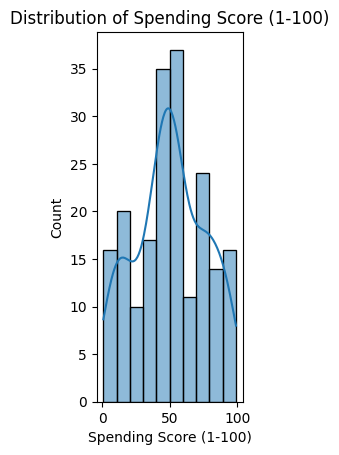


Generating Pairplot for Annual Income and Spending Score...


D:\anaconda3\envs\nnU-Net\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


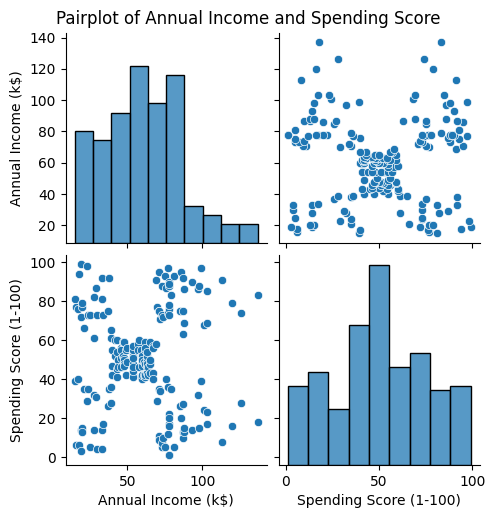

In [3]:
print("\n--- Data Inspection & EDA ---")
print("\nFirst 5 rows of the dataset:")
print(dataset.head())

print("\nDataset information:")
dataset.info()

print("\nDescriptive statistics:")
print(dataset.describe())

print("\nChecking for missing values:")
print(dataset.isnull().sum())
# Observation: No missing values, which simplifies preprocessing.

# Visualizing distributions of key numerical features
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(dataset['Age'], kde=True, bins=10)
plt.title('Distribution of Age')
plt.savefig('distribution_age.png') 
plt.show()


plt.subplot(1, 3, 2)
sns.histplot(dataset['Annual Income (k$)'], kde=True, bins=10)
plt.title('Distribution of Annual Income (k$)')
plt.savefig('distribution_income.png') 
plt.show()

plt.subplot(1, 3, 3)
sns.histplot(dataset['Spending Score (1-100)'], kde=True, bins=10)
plt.title('Distribution of Spending Score (1-100)')
plt.savefig('distribution_spending_score.png') 
plt.show()


# Pairplot to see relationships and distributions
# Consider dropping CustomerID for pairplot, and encoding Gender if using it in pairplot
# For this specific K-Means, we'll only use Annual Income and Spending Score, so pairplot on them.
print("\nGenerating Pairplot for Annual Income and Spending Score...")
selected_features_for_eda = dataset[['Annual Income (k$)', 'Spending Score (1-100)']]
sns.pairplot(selected_features_for_eda)
plt.suptitle('Pairplot of Annual Income and Spending Score', y=1.02)
plt.savefig('pairplot_income_spending.png') 
plt.show()

# -----------------------------------------------------------------------------
# 4. Data Preprocessing
# -----------------------------------------------------------------------------
# Description: Selecting features for clustering. In this case,
# 'Annual Income (k$)' and 'Spending Score (1-100)'.
# No significant cleaning is needed as there are no missing values
# and the selected features are numerical.
# Feature scaling (e.g., StandardScaler) could be applied if features had
# vastly different scales, but for K-Means with these specific features,
# it might not drastically change results as their ranges are somewhat comparable.
# We will proceed without explicit scaling first, as in the original notebook.
# -----------------------------------------------------------------------------


--- Data Preprocessing ---
Selected features for clustering (first 5 rows):
[[15 39]
 [15 81]
 [16  6]
 [16 77]
 [17 40]]

--- Determining Optimal Number of Clusters (Elbow Method) ---
Elbow method plot generated and saved as 'elbow_method_plot.png'.


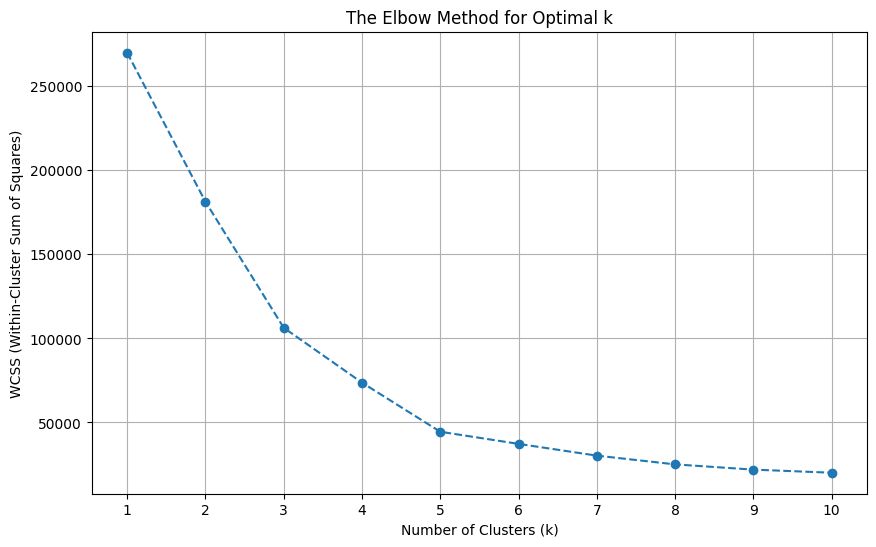

In [4]:
print("\n--- Data Preprocessing ---")
# Selecting the features for clustering
# X will contain 'Annual Income (k$)' (column 3) and 'Spending Score (1-100)' (column 4)
X = dataset.iloc[:, [3, 4]].values
print("Selected features for clustering (first 5 rows):")
print(X[:5])

# Optional: Feature Scaling
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# print("\nScaled features (first 5 rows):")
# print(X_scaled[:5])
# If using scaling, replace X with X_scaled in KMeans fitting.

# -----------------------------------------------------------------------------
# 5. Determining the Optimal Number of Clusters (Elbow Method)
# -----------------------------------------------------------------------------
# Description: Using the Within-Cluster Sum of Squares (WCSS) to find the
# "elbow" point, which suggests an optimal number of clusters.
# Justification: The Elbow method is a common heuristic for K-Means.
# -----------------------------------------------------------------------------
print("\n--- Determining Optimal Number of Clusters (Elbow Method) ---")
wcss = []
for i in range(1, 11):
    kmeans_elbow = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    # n_init=10 is set to run K-Means 10 times with different initial centroids
    # and choose the one with the lowest WCSS. This avoids FutureWarning.
    # random_state for reproducibility.
    kmeans_elbow.fit(X)
    wcss.append(kmeans_elbow.inertia_) # inertia_ attribute gives WCSS

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('The Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.savefig('elbow_method_plot.png') # 图源：肘部法则图
print("Elbow method plot generated and saved as 'elbow_method_plot.png'.")
plt.show()
# Observation: The elbow appears to be around k=5.


# -----------------------------------------------------------------------------
# 6. Model Implementation: Training the K-Means Model
# -----------------------------------------------------------------------------
# Description: Training the K-Means algorithm with the chosen number of
# clusters (k=5 based on the Elbow method).
# Justification: k=5 seems to be a good balance from the elbow plot.
# -----------------------------------------------------------------------------

In [5]:
optimal_k = 5
print(f"\n--- Training K-Means Model with k={optimal_k} ---")
kmeans_model = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
y_kmeans = kmeans_model.fit_predict(X) # fit_predict fits the model and returns cluster labels

print(f"Cluster labels assigned (first 10 customers): {y_kmeans[:10]}")
print(f"Cluster centers (centroids):\n{kmeans_model.cluster_centers_}")


--- Training K-Means Model with k=5 ---
Cluster labels assigned (first 10 customers): [4 2 4 2 4 2 4 2 4 2]
Cluster centers (centroids):
[[55.2962963  49.51851852]
 [86.53846154 82.12820513]
 [25.72727273 79.36363636]
 [88.2        17.11428571]
 [26.30434783 20.91304348]]


# -----------------------------------------------------------------------------
# 7. Evaluation and Analysis: Visualizing the Clusters
# -----------------------------------------------------------------------------
# Description: Plotting the data points colored by their assigned cluster,
# and showing the cluster centroids.
# Justification: Visual inspection is crucial for understanding the segmentation
# quality in clustering.
# -----------------------------------------------------------------------------


--- Visualizing Customer Segments ---
Customer segments plot generated and saved as 'customer_segments_plot.png'.


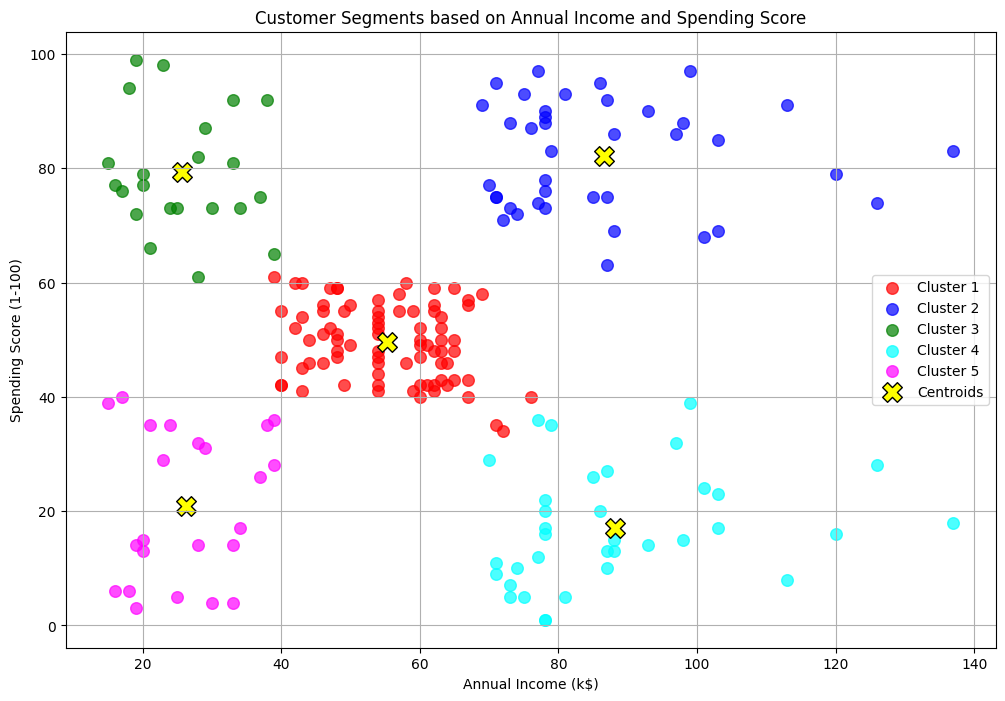

In [6]:
print("\n--- Visualizing Customer Segments ---")
plt.figure(figsize=(12, 8))

colors = ['red', 'blue', 'green', 'cyan', 'magenta'] # Colors for 5 clusters
cluster_labels_legend = [f'Cluster {i+1}' for i in range(optimal_k)]

for i in range(optimal_k):
    plt.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1],
                s=70, c=colors[i], label=cluster_labels_legend[i], alpha=0.7)

# Plotting the centroids
plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:, 1],
            s=200, c='yellow', marker='X', label='Centroids', edgecolors='black')

plt.title('Customer Segments based on Annual Income and Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.grid(True)
plt.savefig('customer_segments_plot.png') # 图源：客户分群图
print("Customer segments plot generated and saved as 'customer_segments_plot.png'.")
plt.show()

# -----------------------------------------------------------------------------
# 8. Model Interpretation and Insights
# -----------------------------------------------------------------------------
# Description: Adding the cluster labels back to the original dataset and
# analyzing the characteristics of each segment.
# Justification: To derive actionable insights from the clusters.
# -----------------------------------------------------------------------------


--- Model Interpretation & Insights ---

Dataset with assigned segments (first 10 rows):
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   
5           6  Female   22                  17                      76   
6           7  Female   35                  18                       6   
7           8  Female   23                  18                      94   
8           9    Male   64                  19                       3   
9          10  Female   30                  19                      72   

   Segment  
0        4  
1        2  
2        4  
3        2  
4        4  
5        2  
6   

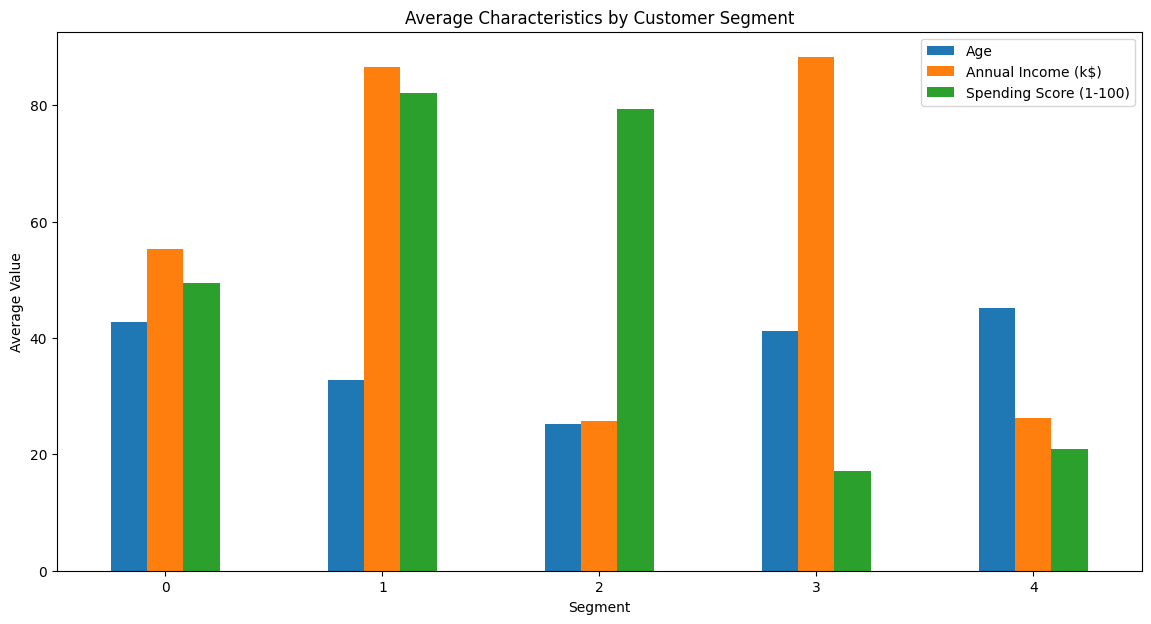

In [7]:
print("\n--- Model Interpretation & Insights ---")
dataset_clustered = dataset.copy()
dataset_clustered['Segment'] = y_kmeans
print("\nDataset with assigned segments (first 10 rows):")
print(dataset_clustered.head(10))

# Analyzing segment characteristics
print("\nAverage characteristics per segment:")
segment_analysis = dataset_clustered.groupby('Segment')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
print(segment_analysis)

# Adding segment counts
segment_analysis['Count'] = dataset_clustered['Segment'].value_counts().sort_index()
print("\nSegment analysis with counts:")
print(segment_analysis)

# Visualizing segment characteristics
segment_analysis.drop('Count', axis=1).plot(kind='bar', figsize=(14, 7))
plt.title('Average Characteristics by Customer Segment')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.savefig('segment_characteristics_barchart.png') # 图源：各客户群特征均值条形图
print("Segment characteristics bar chart saved as 'segment_characteristics_barchart.png'.")
plt.show()


# Potential Naming/Interpretation of Segments (example based on typical results):
# Cluster 0 (e.g., low income, low spend): "Economical / Careful Spenders"
# Cluster 1 (e.g., high income, low spend): "Affluent but Frugal"
# Cluster 2 (e.g., average income, average spend): "Standard / Average Customers"
# Cluster 3 (e.g., low income, high spend): "Careless Spenders / Potential Debt?" OR "Young Enthusiasts"
# Cluster 4 (e.g., high income, high spend): "Target / High Value Customers"
# (Actual interpretation depends on the specific centroid values and distributions)

# -----------------------------------------------------------------------------
# 9. Saving the Results
# -----------------------------------------------------------------------------
# Description: Saving the dataset with assigned cluster labels.
# -----------------------------------------------------------------------------

In [8]:
try:
    dataset_clustered.to_csv('Mall_Customers_Segmented.csv', index=False)
    print("\nDataset with segments saved to 'Mall_Customers_Segmented.csv'")
except Exception as e:
    print(f"Error saving segmented dataset: {e}")


Dataset with segments saved to 'Mall_Customers_Segmented.csv'


# -----------------------------------------------------------------------------
# 10. Communication: Summary & Recommendations (Conceptual for this script)
# -----------------------------------------------------------------------------
# This section would typically be expanded in a Jupyter Notebook's markdown cells
# or a separate report (README.md as per PDF).
#
# Problem Statement: To segment mall customers based on their annual income and
# spending score to identify distinct groups for targeted marketing strategies.
#
# Key Findings:
# - The Elbow method suggested 5 distinct customer segments.
# - Visualization of these segments showed clear groupings.
# - Analysis of segment characteristics (e.g., average income, spending score, age)
#   helps in profiling each segment (e.g., "High Earners, High Spenders",
#   "Low Earners, Low Spenders", etc.).
#
# Model Performance:
# - K-Means successfully partitioned the customers into 5 visually distinct groups.
# - The WCSS was minimized for k=5 relative to other k values as per the elbow plot.
# - Further evaluation could involve silhouette scores for a more quantitative measure
#   of cluster cohesion and separation.
#
# Potential Improvements & Future Work:
# - Incorporate other features (e.g., 'Age', 'Gender' after encoding) into clustering,
#   potentially requiring feature scaling.
# - Use other clustering algorithms (e.g., DBSCAN, Hierarchical Clustering) and compare results.
# - Collect more data or features for richer segmentation.
# - Perform A/B testing of marketing strategies targeted at these segments.
# - Calculate Silhouette Score for a quantitative evaluation of cluster quality.
# -----------------------------------------------------------------------------

In [9]:
print("\n--- Project Completion ---")
print("The script has finished executing. Please review the generated plots and the segmented CSV file.")


--- Project Completion ---
The script has finished executing. Please review the generated plots and the segmented CSV file.
